# Задача - обучить модель OCR для распознавания капчи

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import train_test_split
from PIL import Image
from torchmetrics.functional import char_error_rate

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Подготовка данных.

In [2]:
DATA_DIR = 'data/'
BATCH_SIZE = 8

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_list):
        self.img_list = img_list
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):    
        path = self.img_list[idx]

        label = os.path.basename(path).split('.')[0].lower().strip()
        img = Image.open(path).convert('RGB')

        image = self.transform(img)
        return image, label

In [4]:
path_list = os.listdir(DATA_DIR)
abspath = os.path.abspath(DATA_DIR)

img_list = [os.path.join(abspath, path) for path in path_list]

train_list, val_list = train_test_split(
    img_list, test_size=0.2, random_state=42)

train_dataset = CustomImageDataset(train_list)
val_dataset = CustomImageDataset(val_list)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [5]:
CHARS = 'abcdefghijklmnopqrstuvwxyz0123456789'
VOCAB_SIZE = len(CHARS) + 1

# Создание и обучение модели.

In [6]:
class CRNN(nn.Module):

    def __init__(self, vocab_size):
        super(CRNN, self).__init__()
        
        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(512, 512, (2,2), stride=1, padding=0),
            nn.Dropout(0.5)
        )

        self.mapseq = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Dropout(0.5)
        )
        
        self.lstm = nn.LSTM(512, 256, num_layers=2, bidirectional=True)  

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )
        
        
    def forward(self, x):
        x = self.convlayer(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.mapseq(x)
        x, _ = self.lstm(x)
        x = self.out(x)   
        return x.permute(1, 0, 2)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

crnn = CRNN(VOCAB_SIZE).to(device)
critertion = nn.CTCLoss(blank=0)

char2idx = {}
idx2char = {}

characters = CHARS.lower() + '-'
for i, char in enumerate(characters):
    char2idx[char] = i + 1
    idx2char[i + 1] = char


def calculate_loss(logits, labels):
    length_per_label = [len(label) for label in labels]
    joined_label = ''.join(labels)

    joined_encoding = []
    for char in joined_label:
        joined_encoding.append(char2idx[char]) 

    encoded_labels = torch.IntTensor(joined_encoding)
    labels_len = torch.IntTensor(length_per_label)

    logits_lens = torch.full(
        size=(logits.size(1),), 
        fill_value=logits.size(0), 
        dtype=torch.int32
    ).to(device)

    return critertion(
        logits.log_softmax(2), encoded_labels, 
        logits_lens, labels_len
    )


def train(num_epochs, optimizer, train_loader, val_loader):
    train_losses, valid_losses = [], []

    for epoch in range(num_epochs):

        tot_train_loss = 0
        crnn.train()
        for i, (images, labels) in enumerate(train_loader):
            logits = crnn(images.to(device))
            optimizer.zero_grad()
            train_loss = calculate_loss(logits, labels)
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                crnn.parameters(),
                max_norm=10, norm_type=2.0)
            optimizer.step()

            tot_train_loss += train_loss.item()

        with torch.no_grad():

            tot_val_loss = 0
            crnn.eval()
            for i, (images, labels) in enumerate(val_loader):
                logits = crnn(images.to(device))
                val_loss = calculate_loss(logits, labels)

                tot_val_loss += val_loss.item()

            train_loss = tot_train_loss / len(train_loader.dataset)
            val_loss = tot_val_loss / len(val_loader.dataset)

            train_losses.append(train_loss)
            valid_losses.append(val_loss)
            scheduler.step(val_loss)

        print('Epoch [{:5d} of {:5d}] | train loss {:6.4f} | val loss {:6.4f}'.format(
            epoch+1,
            num_epochs,
            train_loss,
            val_loss
        )) 

    return train_losses, valid_losses

In [8]:
lr = 0.04
weight_decay = 1e-5
momentum = 0.7

EPOCHS = 30

In [9]:
optimizer = optim.SGD(
    crnn.parameters(), lr=lr,
    weight_decay=weight_decay,
    nesterov=True, momentum=momentum
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1,
    patience=3, eps=1e-4, verbose=True
)

train_losses, val_losses = train(EPOCHS, optimizer, train_loader, val_loader)

Epoch [    1 of    30] | train loss 0.4330 | val loss 0.4153
Epoch [    2 of    30] | train loss 0.4083 | val loss 0.4121
Epoch [    3 of    30] | train loss 0.4072 | val loss 0.4117
Epoch [    4 of    30] | train loss 0.4067 | val loss 0.4074
Epoch [    5 of    30] | train loss 0.4060 | val loss 0.4117
Epoch [    6 of    30] | train loss 0.4033 | val loss 0.3996
Epoch [    7 of    30] | train loss 0.3810 | val loss 0.3570
Epoch [    8 of    30] | train loss 0.3406 | val loss 0.3281
Epoch [    9 of    30] | train loss 0.2908 | val loss 0.2553
Epoch [   10 of    30] | train loss 0.2212 | val loss 0.2047
Epoch [   11 of    30] | train loss 0.1577 | val loss 0.1356
Epoch [   12 of    30] | train loss 0.1118 | val loss 0.0985
Epoch [   13 of    30] | train loss 0.0833 | val loss 0.0745
Epoch [   14 of    30] | train loss 0.0638 | val loss 0.0694
Epoch [   15 of    30] | train loss 0.0455 | val loss 0.0444
Epoch [   16 of    30] | train loss 0.0348 | val loss 0.0449
Epoch [   17 of    30] |

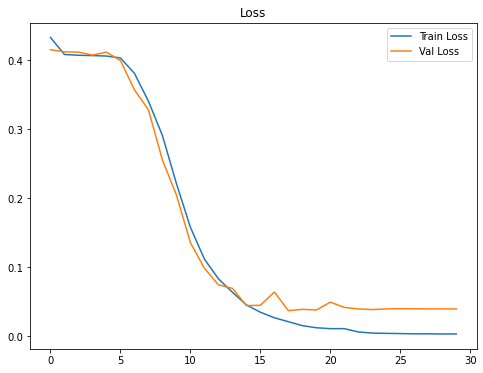

In [10]:
fig = plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [11]:
summary(crnn)

Layer (type:depth-idx)                   Param #
CRNN                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       73,856
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       295,168
│    └─ReLU: 2-10                        --
│    └─MaxPool2d: 2-11                   --
│    └─Conv2d: 2-12                      1,180,160
│    └─BatchNorm2d: 2-13                 1,024
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      2,359,808
│    └─BatchNorm2d: 2-16                 1,024
│    └─ReLU: 2-17                        --
│    └─MaxPool2d: 2-18                   --
│    └─Conv2d: 2-19                  

# Подсчет метрик.

In [12]:
def decode(logits):
    tokens = logits.softmax(2).argmax(2).squeeze(1)

    tokens = ''.join([idx2char[token] 
                    if token != 0  else '-' 
                    for token in tokens.numpy()])
    tokens = tokens.split('-')

    text = [char 
            for batch_token in tokens 
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx-1] or len(batch_token) == 1]
    text = ''.join(text)

    return text

In [13]:
list_label = []
list_pred_text = []
sample_result = []

for indx, (img, label) in enumerate(val_dataset):
    logits = crnn(img.unsqueeze(0).to(device))
    pred_text = decode(logits.cpu())
    list_label.append(label)
    list_pred_text.append(pred_text)
    
    err = char_error_rate(label, pred_text)
    sample_result.append((err, img, label, pred_text))

error = char_error_rate(list_label, list_pred_text)
error

tensor(0.0479)

# Анализ ошибок модели.

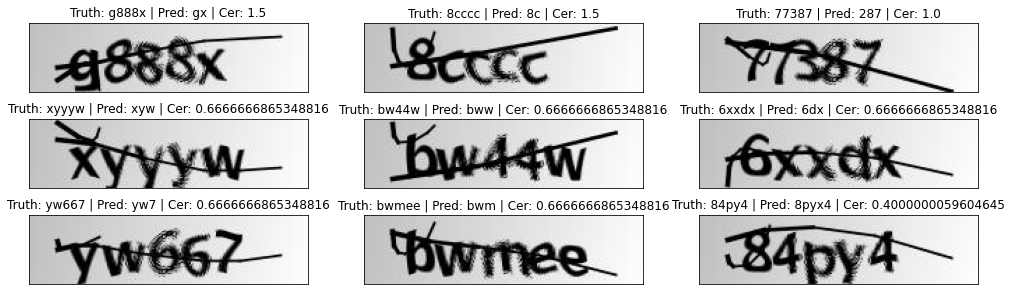

In [14]:
sample_result = sorted(sample_result, key=lambda x: x[0], reverse=True)

fig = plt.figure(figsize=(17, 5))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])

    err, img, label, pred_text = sample_result[i]
    title = f'Truth: {label} | Pred: {pred_text} | Cer: {err}'

    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(title)

plt.show()

Для решения задачи была применена архитектуру CRNN приведенную в статье https://arxiv.org/pdf/1507.05717.pdf  

При обучении были использованы такие подходы как:  
- "clip" градиентов — ограничение величин градиентов  
- динамическое снижение скорости обучения

От оригинальной архитектуры модель отличается использованием метода "dropout"

Очевидно, у модели проблемы с повторяющимися символами, для решения этой проблемы нужно будет изменить подход (другая модель). Также стоит заметить, не была использована информация о количестве символов (у нас оно фиксированное и равно 5) 

Итоговая метрика на тесте составила 4.8% (доля неверно распознанных символов)